In [1]:
# !conda install -c conda-forge librosa

# !conda install tqdm

import torch as ch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as Data

import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline

import os
import string
import librosa
import tqdm
import shutil
# !pip install lws
import lws
import IPython.display as ipd
from importlib import reload

import utils
reload(utils)
import hyperparams
reload(hyperparams)
import datasets
reload(datasets)
import dcttsModel
reload(dcttsModel)

<module 'dcttsModel' from '/home/aduriseti/tts/ettts_master/dcttsModel.py'>

In [2]:
dev = ch.device('cuda:0' if ch.cuda.is_available() else 'cpu')
if ch.cuda.is_available():
    ch.multiprocessing.set_start_method("spawn",force=True)

In [3]:
# params = hyperparams.Hyperparams()
ssrnParams = hyperparams.Hyperparams(sep=1,pad=None,chunk=None)
text2MelParams = hyperparams.Hyperparams(sep=0,pad=2)
ssrn = dcttsModel.SSRN(ssrnParams).to(dev)
text2Mel = dcttsModel.Text2Mel(text2MelParams).to(dev)

# print tunable hyperparams
print('TEXT2MEL HYPERPARAMS',text2MelParams.paramDict)
print('SSRN HYPERPARAMS',ssrnParams.paramDict)
[sum(np.prod(p.size()) for p in m.parameters()) for m in (text2Mel,ssrn)]


TEXT2MEL HYPERPARAMS {'sep': 0, 'alpha': 1, 'dropout': 0.05, 'norm': 2, 'lr': 0.001, 'chunk': 1, 'pad': 2, 'reversedDilation': 0}
SSRN HYPERPARAMS {'sep': 1, 'alpha': 1, 'dropout': 0.05, 'norm': 2, 'lr': 0.001, 'reversedDilation': 0}


[23949552, 24980141]

In [4]:
class DbinLoss(ch.nn.Module):
    def __init__(self):
        super(DbinLoss,self).__init__()
    
    def forward(self,Yhat,Y):
        EPS = 1e-12
        elLoss = -(Y*ch.log(Yhat+EPS)+(1-Y)*ch.log(1-Yhat+EPS))
#         return elLoss.view(elLoss.shape[0],-1).mean(1)
        return elLoss.mean()

class GAttLoss(ch.nn.Module):
    def __init__(self):
        super(GAttLoss,self).__init__()
            
    def forward(self,A,I):
        b,N,T = A.shape
        assert I.shape == (b,)
        if text2MelParams.pad == 2:
            W = ch.Tensor([[[np.e**(-(n/N-(t-i)/T)**2 / (2*text2MelParams.g**2)) 
                             for t in range(1,T+1)] 
                            for n in range(1,N+1)]
                           for i in range(b)])
        else:
            W = ch.Tensor([[np.e**(-(n/N-t/T)**2 / (2*text2MelParams.g**2)) 
                             for t in range(1,T+1)] 
                            for n in range(1,N+1)])
        W = W.to(dev)
        return ((1-W)*A).mean()



L1Fun = ch.nn.L1Loss()
BCEFun = ch.nn.BCELoss()
def SpecLossFun(Shat,S): return L1Fun(Shat,S) + BCEFun(Shat,S)
DbinFun = DbinLoss()
GAttFun = GAttLoss()

In [5]:
def text2MelLossFun(text2Mel,batch):
    bL,bS,_,bI = batch
    Shat,A = text2Mel(bL,bS)
    melLoss = SpecLossFun(Shat[:,:,:-text2Mel.params.chunk],bS[:,:,text2Mel.params.chunk:])
#     print(bI)
    attLoss = GAttFun(A,bI)
    return melLoss + attLoss

def text2MelDispFun(text2Mel,batch):
    bL,bS,bY,i = [t[0:1] for t in batch] # only use first element of batch
    print([bL.shape,bS.shape,bY.shape,i.shape])
    print('LOSS:',text2MelLossFun(text2Mel,batch).item())
    Shat,A = text2Mel(bL,bS)
    bL,bS,Shat,A,bY,i = [t[0].cpu().detach().numpy() for t in (bL,bS,Shat,A,bY,i)]
    print('PAD INDEX',i)
    print('TEXT',"".join(text2Mel.params.i2c[c] for c in bL))
    plt.imshow(bS,cmap='gray')
    plt.show()
    plt.imshow(Shat,cmap='gray')
    plt.show()
    plt.imshow(A,cmap='gray')
    plt.show()

In [6]:
text2MelParams = hyperparams.Hyperparams(sep=0,pad=0,dropout=0)
# nWorkers = 8 if ch.cuda.is_available() else 0
nWorkers = 6 if ch.cuda.is_available() else 0
text2MelLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=1,params=text2MelParams),
                                 batch_size=16,
                                 shuffle=True,
                                 num_workers=nWorkers)
text2Mel = dcttsModel.Text2Mel(text2MelParams).to(dev)
text2MelOpt = ch.optim.Adam(text2Mel.parameters(),lr=text2MelParams.lr,
                            betas=(text2MelParams.b1,text2MelParams.b2),
                            eps=text2MelParams.eps)
text2MelWrapper = utils.ModelWrapper(network=text2Mel,optimizer=text2MelOpt,
                                     lossFun=text2MelLossFun,loader=text2MelLoader,
                                     modelName='text2Mel',dev=dev,dispFun=text2MelDispFun)

INITIALIZED text2Mel WITH HYPERPARAMS {'sep': 0, 'alpha': 1, 'dropout': 0, 'norm': 2, 'lr': 0.001, 'chunk': 1, 'pad': 0, 'reversedDilation': 0}
TOTAL PARAM COUNT 23949552


In [7]:
text2MelWrapper.load()

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
LOADED EPOCH 108, LOSS 0.022988801302193707, BEST LOSS 0.022988801302193707 FROM ./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar


EPOCH 108



epoch 108 total 0.022984851365769977
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.022510500624775887
PAD INDEX 0
TEXT he studied the russian language, read a russian language newspaper and seemed interested in what was going on in the soviet union.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


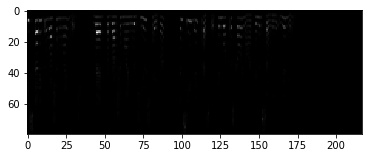

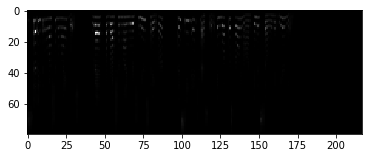

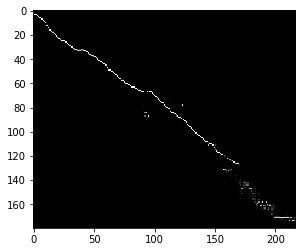

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 109, LOSS 0.022984851365769977, BEST LOSS 0.022984851365769977 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 109



epoch 109 total 0.022984970733523367
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.028880150988698006
PAD INDEX 0
TEXT the wardsman had a monopoly in supplying provisions, gave dinner and breakfast at his own price, and was such complete master of the wardNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


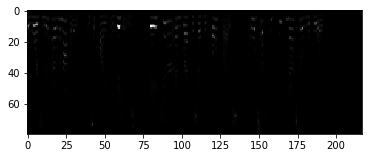

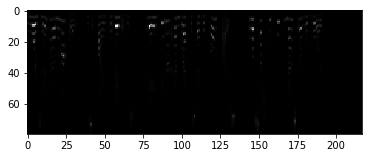

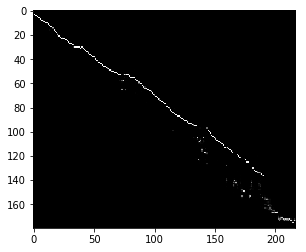

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 110, LOSS 0.022984970733523367, BEST LOSS 0.022984851365769977 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 110



epoch 110 total 0.02298504300137509
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.03235762193799019
PAD INDEX 0
TEXT as president kennedy and governor connally were being removed from the limousine onto stretchers,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


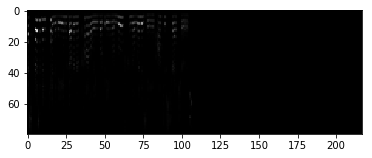

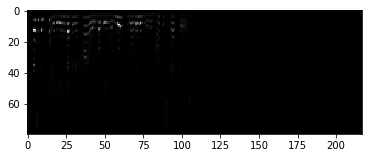

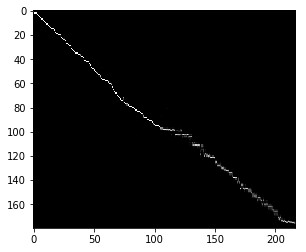

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 111, LOSS 0.02298504300137509, BEST LOSS 0.022984851365769977 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 111



epoch 111 total 0.022980186315392382
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.034786075353622437
PAD INDEX 0
TEXT mr. e. g. wakefield took part in the scheme for the colonization of north australia, and for some years resided in that colony.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


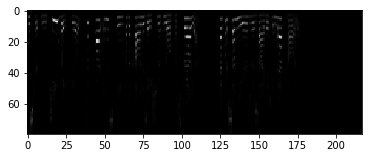

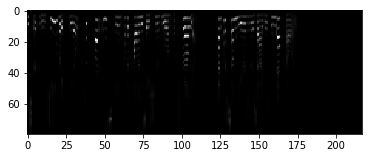

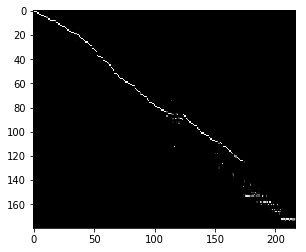

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 112, LOSS 0.022980186315392382, BEST LOSS 0.022980186315392382 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 112



epoch 112 total 0.022956934254338493
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.018010558560490608
PAD INDEX 0
TEXT the mail-order coupon listed the purchaser as "a. j. hidell age twenty-eight"NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


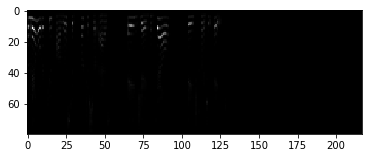

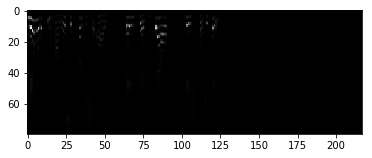

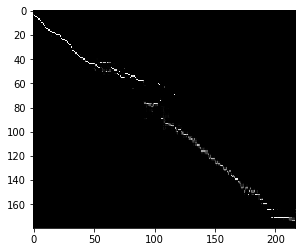

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 113, LOSS 0.022956934254338493, BEST LOSS 0.022956934254338493 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 113



epoch 113 total 0.022957312449145673
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.02305682748556137
PAD INDEX 0
TEXT time was clearly an important factor in the fraud, hence the bills were sent forward in quick succession.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


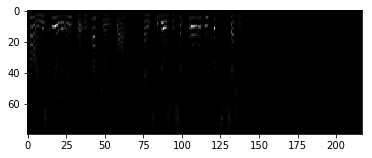

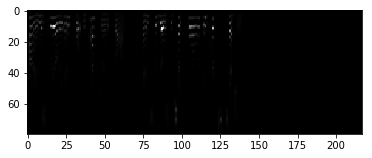

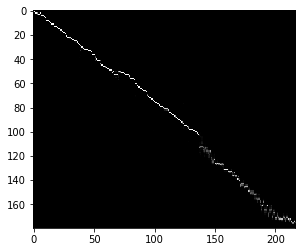

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 114, LOSS 0.022957312449145673, BEST LOSS 0.022956934254338493 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 114



epoch 114 total 0.022955724702619796
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.02844719961285591
PAD INDEX 0
TEXT "it is well known," likewise comments le conte,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


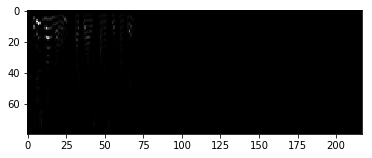

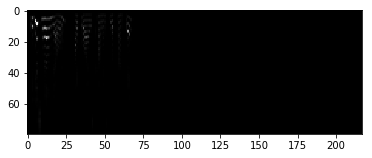

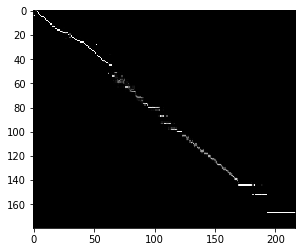

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 115, LOSS 0.022955724702619796, BEST LOSS 0.022955724702619796 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 115



epoch 115 total 0.022936278683091723
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.015349852852523327
PAD INDEX 0
TEXT where a workman found a bundle containing two human legs, in a drain.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


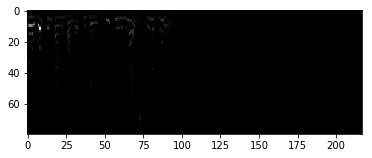

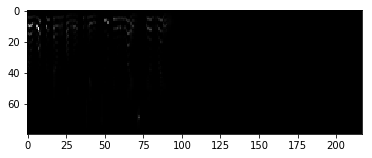

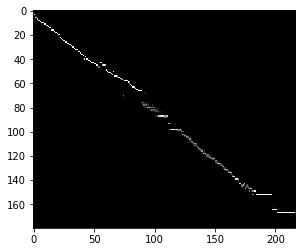

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 116, LOSS 0.022936278683091723, BEST LOSS 0.022936278683091723 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 116



epoch 116 total 0.022938218921311756
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.023222051560878754
PAD INDEX 0
TEXT and considerably better living quarters than those accorded to soviet citizens of equal age and station.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


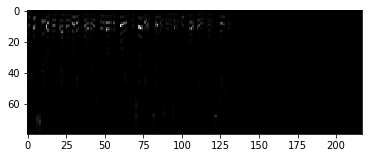

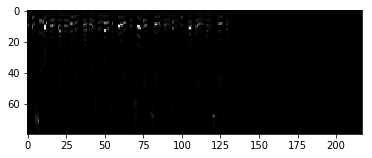

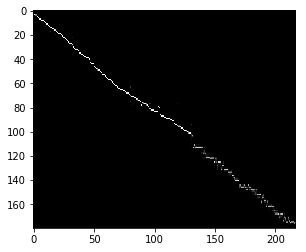

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 117, LOSS 0.022938218921311756, BEST LOSS 0.022936278683091723 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 117



epoch 117 total 0.02294739393600777
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.0347038134932518
PAD INDEX 0
TEXT the wildest and most cut-throat looking of the lot, which proves that he could be grateful for kindness, and was not all bad.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


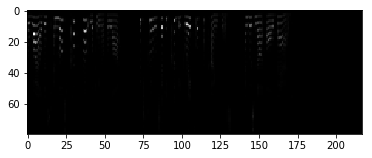

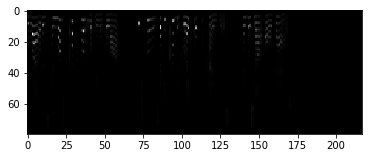

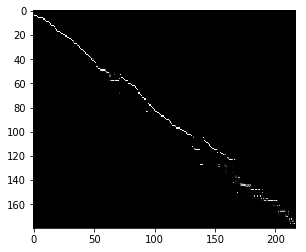

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 118, LOSS 0.02294739393600777, BEST LOSS 0.022936278683091723 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 118



epoch 118 total 0.022928436848321066
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.02379898726940155
PAD INDEX 0
TEXT my heart has undergone that horrible penalty.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


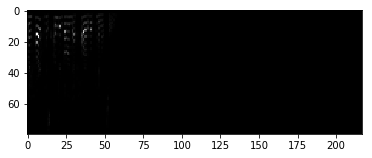

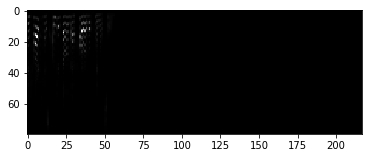

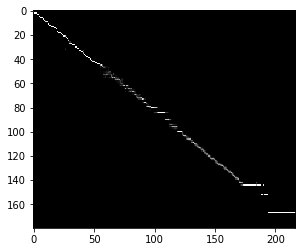

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 119, LOSS 0.022928436848321066, BEST LOSS 0.022928436848321066 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 119



epoch 119 total 0.02293989743425775
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.03675822168588638
PAD INDEX 0
TEXT most important, notwithstanding that both agencies have professed to the commission that the liaison between them was close and fully sufficient,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


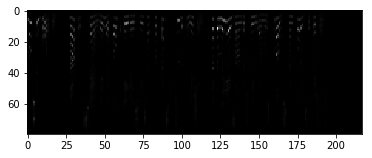

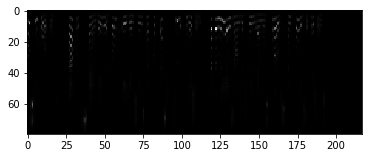

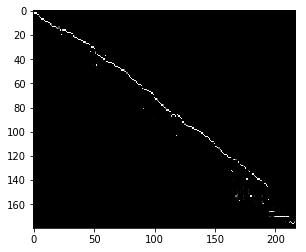

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 120, LOSS 0.02293989743425775, BEST LOSS 0.022928436848321066 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 120



epoch 120 total 0.02292976042450364
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.03316476568579674
PAD INDEX 0
TEXT it is now time to review these actions as a whole to determine through deliberative means in the light of experience,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


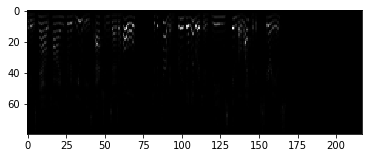

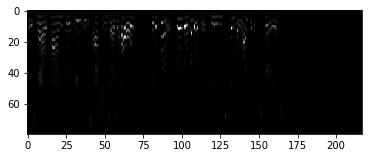

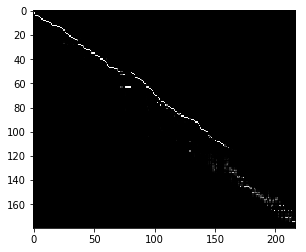

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 121, LOSS 0.02292976042450364, BEST LOSS 0.022928436848321066 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 121


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 123 total 0.022916441155013755
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.032973773777484894
PAD INDEX 0
TEXT female prisoners were still exposed to the full view of the males, the netting in front of the gallery being perfectly useless as a screen.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


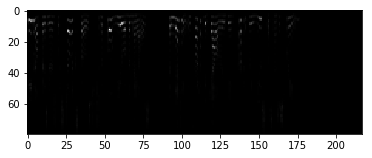

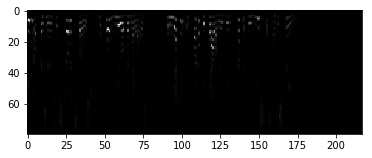

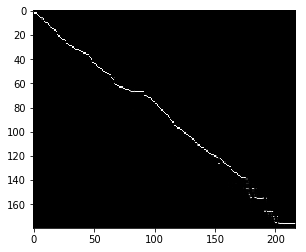

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 124, LOSS 0.022916441155013755, BEST LOSS 0.022907548201784714 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 124



epoch 124 total 0.02290345211860849
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.026618551462888718
PAD INDEX 0
TEXT calcraft, who, in spite of the dreadful calling he subsequently followed, was always reputed a kindly man,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


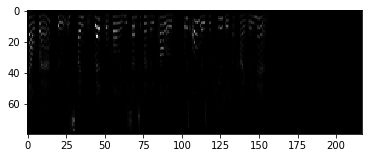

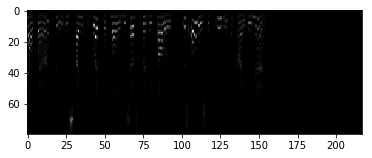

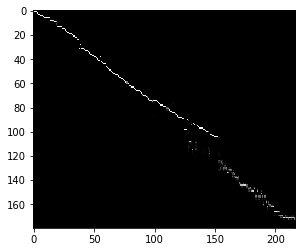

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 125, LOSS 0.02290345211860849, BEST LOSS 0.02290345211860849 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 125



epoch 125 total 0.02289519261624386
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.022034017369151115
PAD INDEX 0
TEXT turning to his right in the direction of the noise, kellerman heard the president sayNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


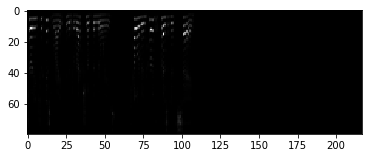

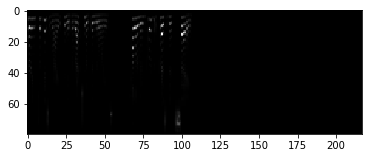

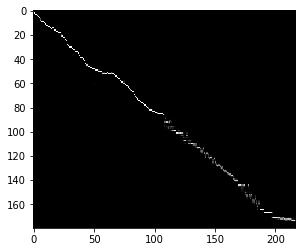

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 126, LOSS 0.02289519261624386, BEST LOSS 0.02289519261624386 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 126


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 129 total 0.02287916687331093
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.02621459774672985
PAD INDEX 0
TEXT it is satisfactory to be able to record that some consideration was shown the capital convict actually awaiting execution.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


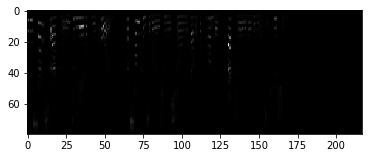

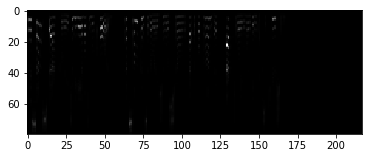

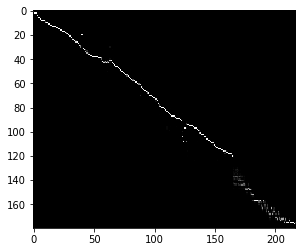

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 130, LOSS 0.02287916687331093, BEST LOSS 0.02287765054671622 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 130



epoch 130 total 0.02288461742060843
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.03397112339735031
PAD INDEX 0
TEXT he had left a note for his wife telling her what to do in case he were apprehended, as well as his notebook and the pictures of himself holding the rifle.NNNNNNNNNNNNNNNNNNNNNNNNNN


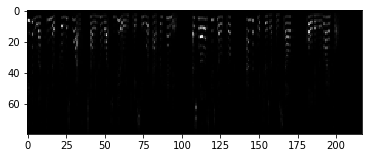

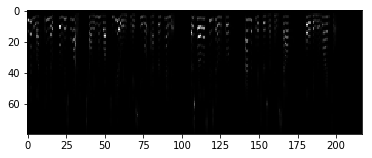

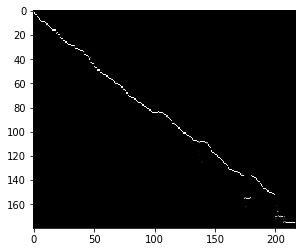

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 131, LOSS 0.02288461742060843, BEST LOSS 0.02287765054671622 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 131


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 134 total 0.022868818128064496
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.034154266119003296
PAD INDEX 0
TEXT that while he did not fire oswald because of the newspaper incident or even weigh it heavily in his decision, quote,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


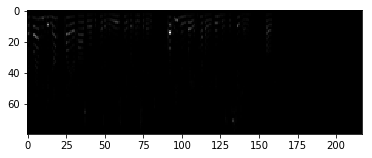

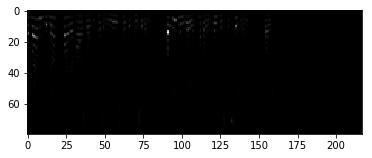

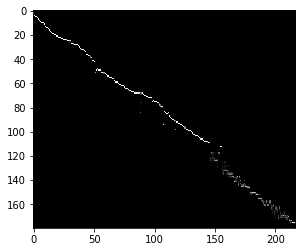

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 135, LOSS 0.022868818128064496, BEST LOSS 0.022861770187407288 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 135



epoch 135 total 0.022848864931112794
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.019962161779403687
PAD INDEX 0
TEXT but according to the opposite view no reason can be assigned why such should be the case.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


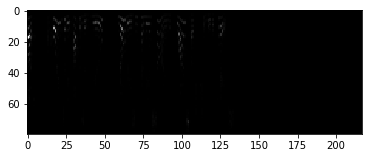

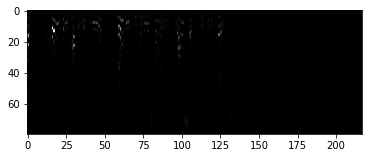

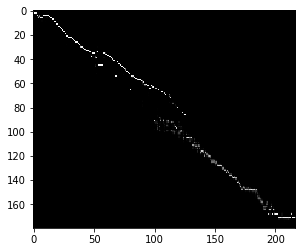

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 136, LOSS 0.022848864931112794, BEST LOSS 0.022848864931112794 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 136


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 139 total 0.022847903717253634
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.03522356227040291
PAD INDEX 0
TEXT which would indicate that the bullet was not fired from the mannlicher-carcano rifle owned by lee harvey oswald.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


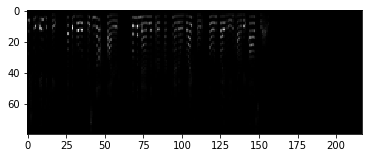

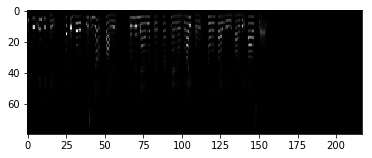

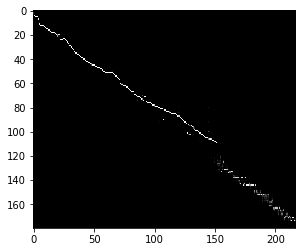

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 140, LOSS 0.022847903717253634, BEST LOSS 0.022840664666424048 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 140



epoch 140 total 0.022827792117622363
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.01799093745648861
PAD INDEX 0
TEXT with the headquarters of the federal intelligence agencies, particularly the fbi,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


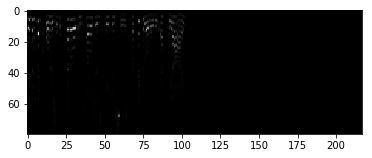

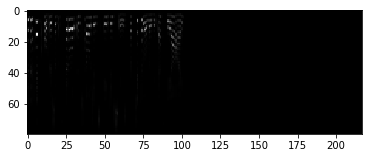

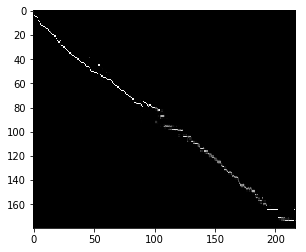

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 141, LOSS 0.022827792117622363, BEST LOSS 0.022827792117622363 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 141


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 144 total 0.022818957341473493
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.025805605575442314
PAD INDEX 0
TEXT for bizarre reasons or by writing or in some other way attempting to communicate with him in a threatening or abusive mannerNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


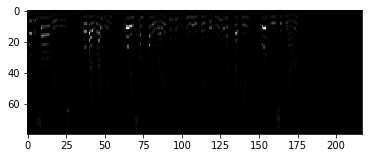

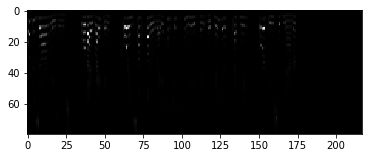

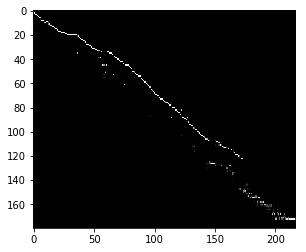

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 145, LOSS 0.022818957341473493, BEST LOSS 0.022812334366087147 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 145



epoch 145 total 0.02280615915947441
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.016572898253798485
PAD INDEX 0
TEXT sold out so large an amount of stock, that he paid sixteen thousand pounds a year in dividends to escape detection.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


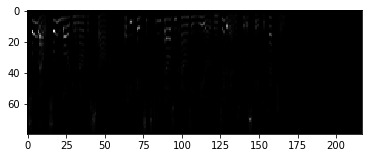

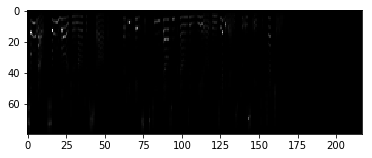

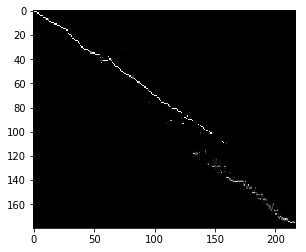

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 146, LOSS 0.02280615915947441, BEST LOSS 0.02280615915947441 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 146


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 149 total 0.022802511558159076
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.02714655175805092
PAD INDEX 0
TEXT a firm which held a lot of warrants suddenly demanded the delivery of the goods they covered.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


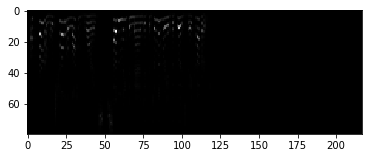

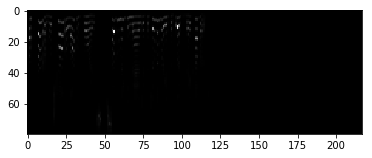

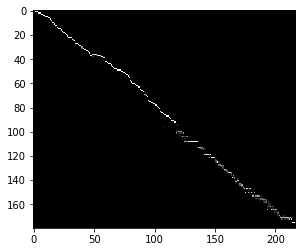

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 150, LOSS 0.022802511558159076, BEST LOSS 0.022802511558159076 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 150



epoch 150 total 0.022799133248071174
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.026883551850914955
PAD INDEX 0
TEXT determination to use a means, other than legal or peaceful, to satisfy his grievance, end quote, within the meaning of the new criteria.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


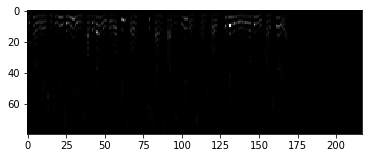

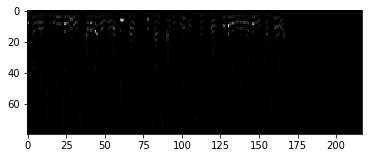

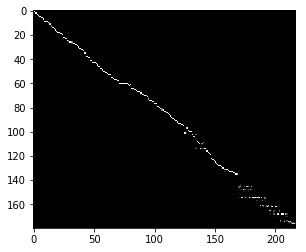

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 151, LOSS 0.022799133248071174, BEST LOSS 0.022799133248071174 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 151


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 154 total 0.022789300602874648
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.02991544082760811
PAD INDEX 0
TEXT it was more in terms of a general hostility against the government and its representatives rather than a grudge against any particular person.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


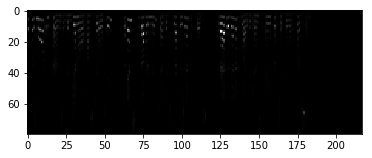

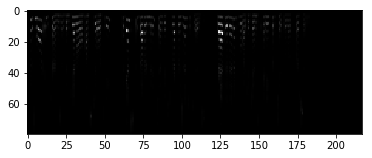

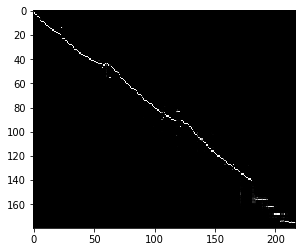

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 155, LOSS 0.022789300602874648, BEST LOSS 0.02277909283206534 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 155



epoch 155 total 0.02277504748928903
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.020568519830703735
PAD INDEX 0
TEXT william the fourth was also the victim of a murderous outrage on ascot race-course in eighteen thirty-two,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


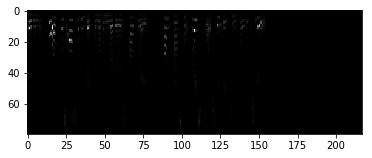

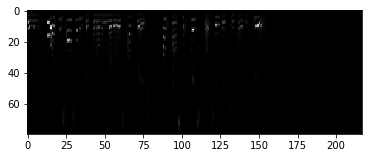

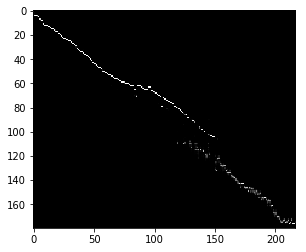

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 156, LOSS 0.02277504748928903, BEST LOSS 0.02277504748928903 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 156


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 156 total 0.02277985837088147
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.028793375939130783
PAD INDEX 0
TEXT it was no longer possible to stop a coach or carriage, or rob the postman who carried the mail.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


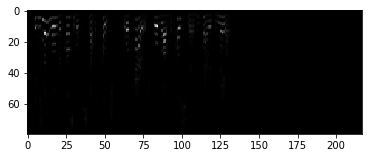

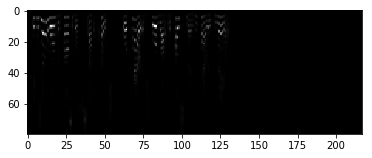

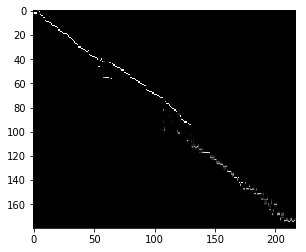

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 157, LOSS 0.02277985837088147, BEST LOSS 0.02277504748928903 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 157



epoch 157 total 0.02276879439769841
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.021640915423631668
PAD INDEX 0
TEXT few social agencies even in new york were equipped to provide the kind of intensive treatment that he needed,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


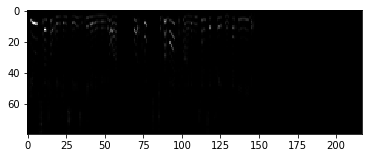

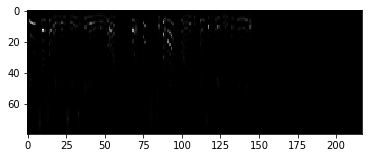

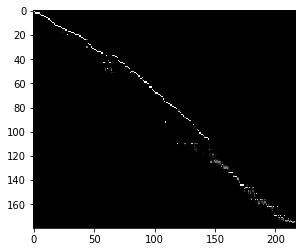

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 158, LOSS 0.02276879439769841, BEST LOSS 0.02276879439769841 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 158



epoch 158 total 0.022765723293396965
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.02170582301914692
PAD INDEX 0
TEXT may be determined and any later adjustments shall be made either by agreement or, in case of disagreement,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


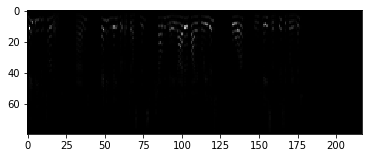

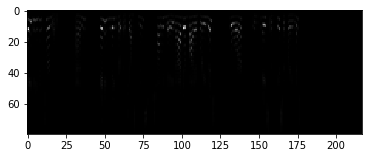

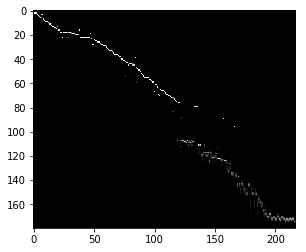

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 159, LOSS 0.022765723293396965, BEST LOSS 0.022765723293396965 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 159



epoch 159 total 0.022758496160716263
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.018675711005926132
PAD INDEX 0
TEXT liberal-minded judiciary necessary to furnish quicker and cheaper justice from bottom to top.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


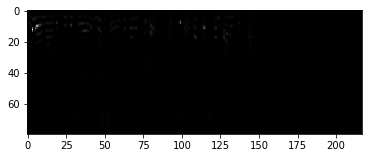

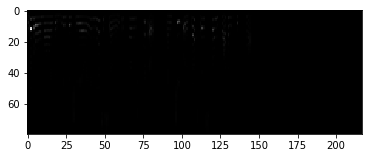

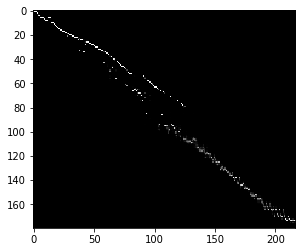

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 160, LOSS 0.022758496160716263, BEST LOSS 0.022758496160716263 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 160



epoch 160 total 0.022765657111112753
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.026563208550214767
PAD INDEX 0
TEXT on november four, sorrels told behn he believed security difficulties at the trade mart could be overcome by special precautions.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


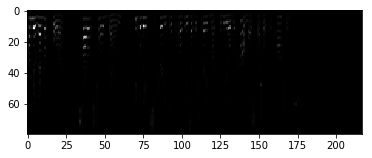

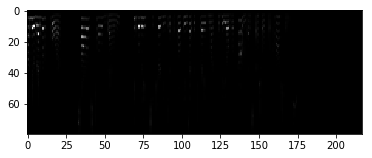

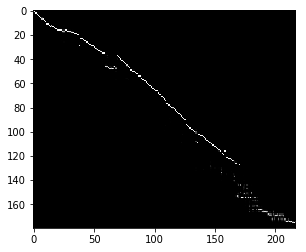

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 161, LOSS 0.022765657111112753, BEST LOSS 0.022758496160716263 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 161



epoch 161 total 0.022748169719950476
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.014923375099897385
PAD INDEX 0
TEXT special agent in charge of the dallas office. both agents were advised of the trip on november four.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


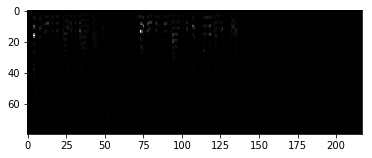

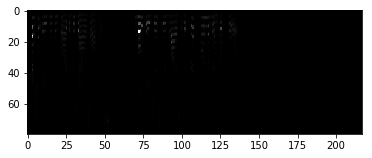

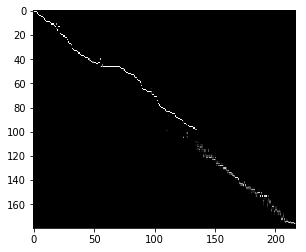

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 162, LOSS 0.022748169719950476, BEST LOSS 0.022748169719950476 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 162



epoch 162 total 0.0227630570308486
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.030451714992523193
PAD INDEX 0
TEXT her face was comely, she had dark hair and good eyes, and was above the middle height, yet inclined to be stout.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


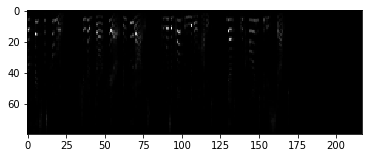

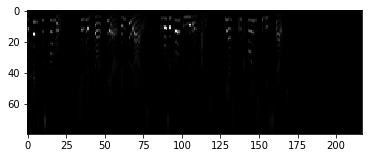

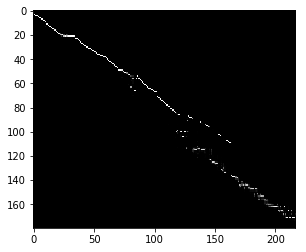

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 163, LOSS 0.0227630570308486, BEST LOSS 0.022748169719950476 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 163



epoch 163 total 0.02275450364200037
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.025455214083194733
PAD INDEX 0
TEXT would have amounted to sixty-eight thousand, seven hundred twenty-eight pounds, and if defended,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


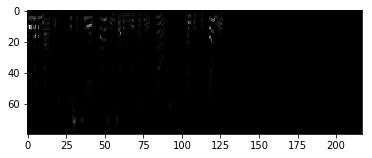

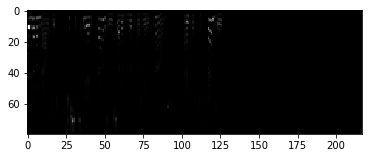

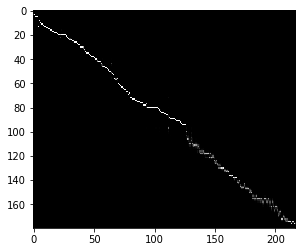

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 164, LOSS 0.02275450364200037, BEST LOSS 0.022748169719950476 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 164



epoch 164 total 0.022763007187020422
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.035425491631031036
PAD INDEX 0
TEXT and by the following year forty-seven new cells had been built on the most approved plan.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


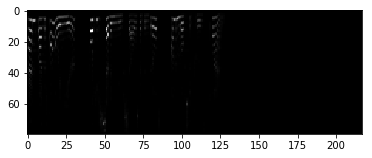

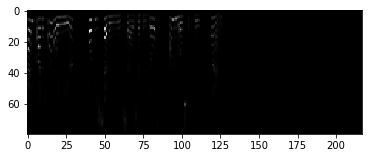

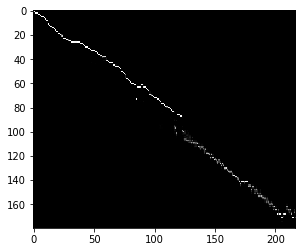

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 165, LOSS 0.022763007187020422, BEST LOSS 0.022748169719950476 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 165



epoch 165 total 0.022747366666905026
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.02313872240483761
PAD INDEX 0
TEXT he may not have intended to go to the soviet union directly, if at all. it appears that he really wanted to go to cuba.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


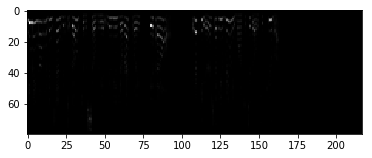

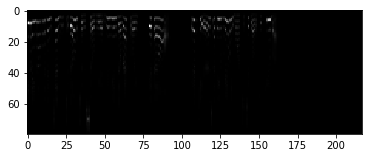

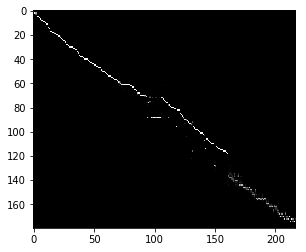

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 166, LOSS 0.022747366666905026, BEST LOSS 0.022747366666905026 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 166



epoch 166 total 0.022742480628970843
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.021649349480867386
PAD INDEX 0
TEXT are often designated organic functions.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


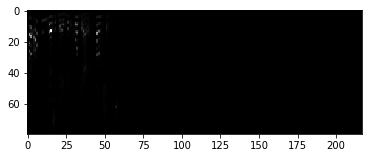

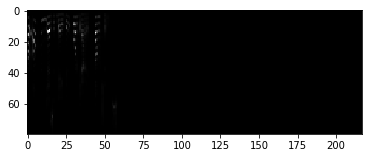

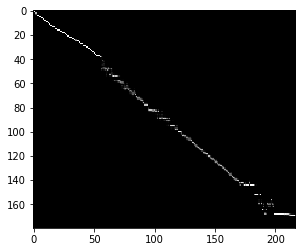

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 167, LOSS 0.022742480628970843, BEST LOSS 0.022742480628970843 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 167



epoch 167 total 0.022738404866697183
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.021739371120929718
PAD INDEX 0
TEXT because other types of fibers present in the blanket were not found in the bag.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


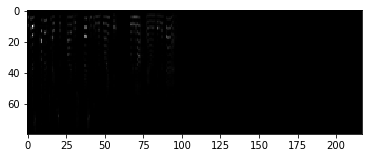

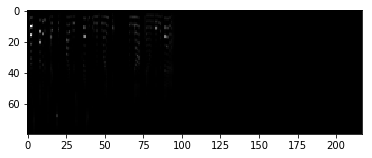

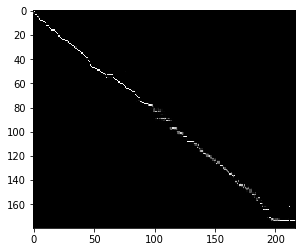

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 168, LOSS 0.022738404866697183, BEST LOSS 0.022738404866697183 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 168



epoch 168 total 0.022729991729468553
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.01696339249610901
PAD INDEX 0
TEXT on the fatal morning he came gaily out of his cell,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


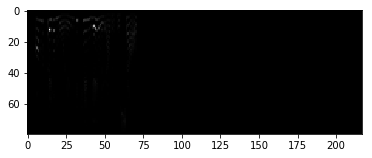

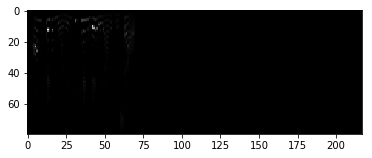

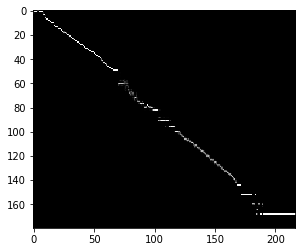

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 169, LOSS 0.022729991729468553, BEST LOSS 0.022729991729468553 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 169



epoch 169 total 0.022731706374950374
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.021501334384083748
PAD INDEX 0
TEXT and robert i. bouck, who was in charge of the protective research section of the secret service, believed that the accumulation of the facts known to the fbiNNNNNNNNNNNNNNNNNNNNNNN


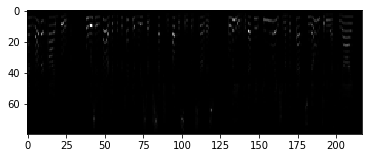

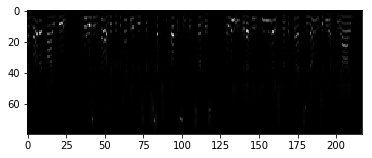

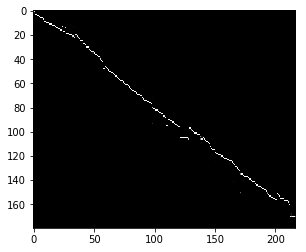

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 170, LOSS 0.022731706374950374, BEST LOSS 0.022729991729468553 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 170



epoch 170 total 0.022736885126179725
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.028199171647429466
PAD INDEX 0
TEXT supplies of common necessaries, such as have now been part of the furniture of every british jail for many years,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


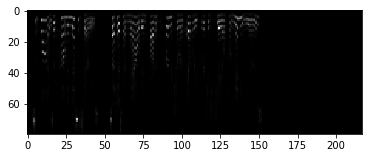

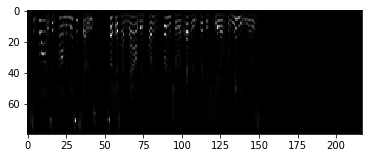

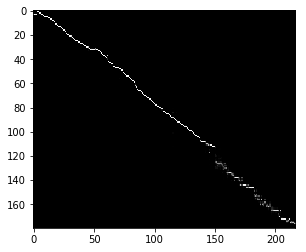

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 171, LOSS 0.022736885126179725, BEST LOSS 0.022729991729468553 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 171



epoch 171 total 0.022734326824768267
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.02799053117632866
PAD INDEX 0
TEXT he took walks and visited museums, and sometimes rode a rented bicycle in the park on saturday mornings.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


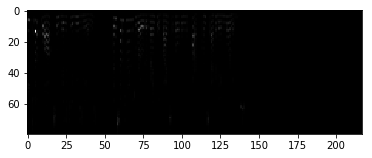

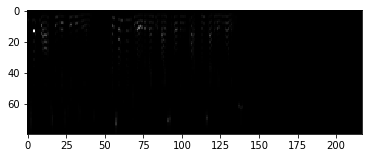

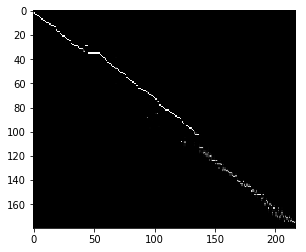

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 172, LOSS 0.022734326824768267, BEST LOSS 0.022729991729468553 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 172



epoch 172 total 0.022725943954133274
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.023885753005743027
PAD INDEX 0
TEXT all three identified exhibit number one forty-three as the revolver taken from oswald when he was arrested.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


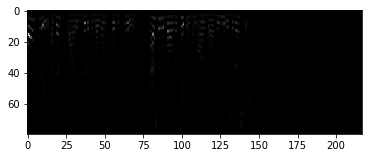

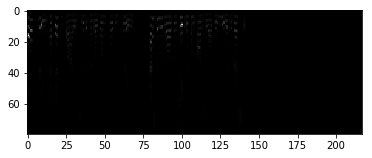

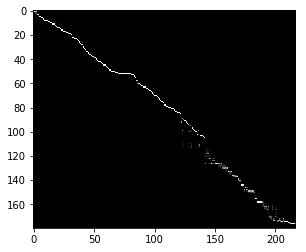

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 173, LOSS 0.022725943954133274, BEST LOSS 0.022725943954133274 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 173



epoch 173 total 0.022729295011220584
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.028484156355261803
PAD INDEX 0
TEXT whom she was to have married, and in whose company she had left her own lodgings to visit his in camberwell.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


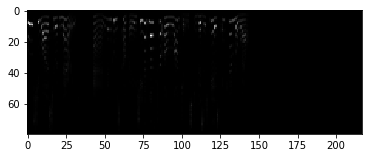

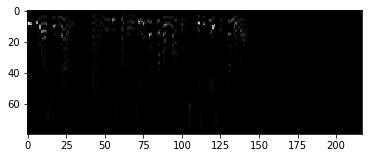

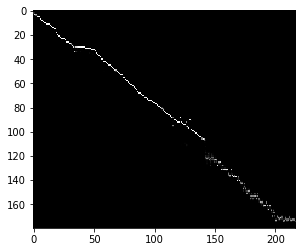

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 174, LOSS 0.022729295011220584, BEST LOSS 0.022725943954133274 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 174



epoch 174 total 0.02272132994023277
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.02340075559914112
PAD INDEX 0
TEXT it passed the commons, but opposition was again encountered in the lords.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


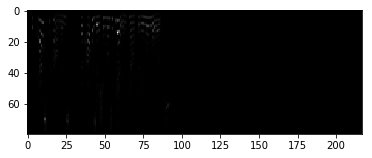

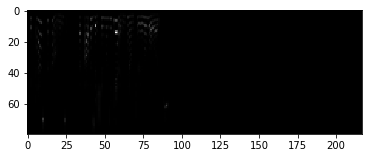

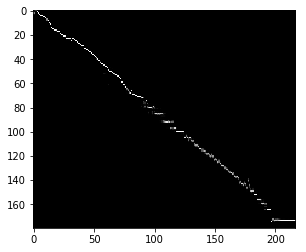

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 175, LOSS 0.02272132994023277, BEST LOSS 0.02272132994023277 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 175



epoch 175 total 0.022725852014524723
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.030380841344594955
PAD INDEX 0
TEXT "all vertebrate animals, and none other," says le conte, "have an internal jointed skeleton worked by muscles on the outside.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


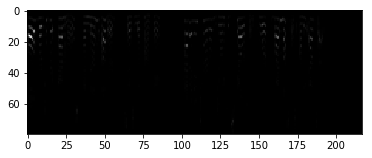

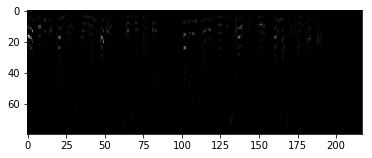

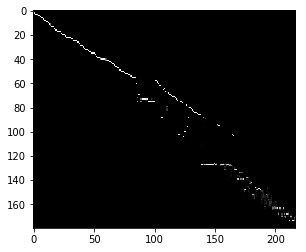

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 176, LOSS 0.022725852014524723, BEST LOSS 0.02272132994023277 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 176



epoch 176 total 0.02271749090625724
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.025712110102176666
PAD INDEX 0
TEXT upon which was raised a second tower, and on that a third, and so on up to eight.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


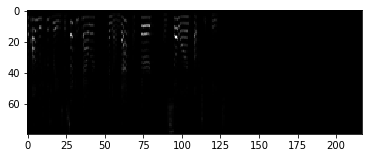

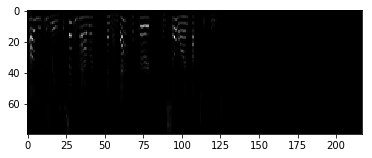

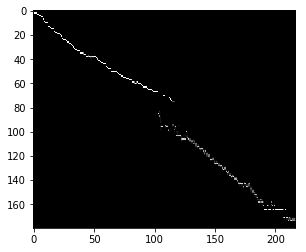

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 177, LOSS 0.02271749090625724, BEST LOSS 0.02271749090625724 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 177


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 180 total 0.02272812485027669
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.044969893991947174
PAD INDEX 0
TEXT till the defalcations from fraudulent transfers and fraudulent issues combined amounted to twenty-seven thousand pounds.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


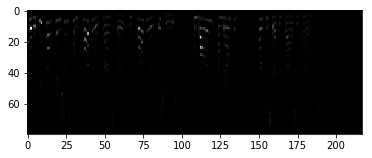

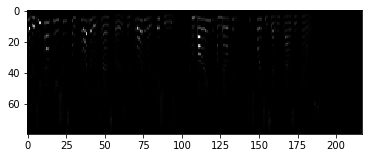

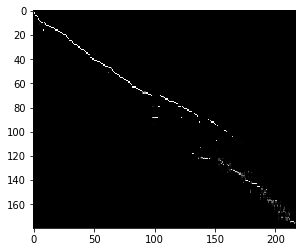

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 181, LOSS 0.02272812485027669, BEST LOSS 0.02270581221569385 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 181



epoch 181 total 0.02269949534379724
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.01973119005560875
PAD INDEX 0
TEXT to fifty-six in eighteen thirty-nine.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


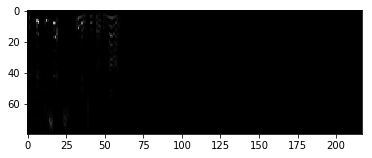

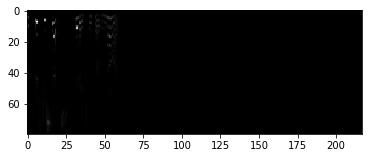

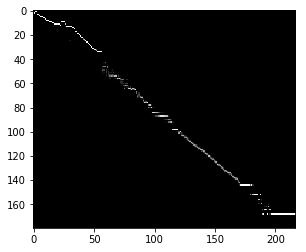

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 182, LOSS 0.02269949534379724, BEST LOSS 0.02269949534379724 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 182


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 185 total 0.02269256371003923
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.023150106891989708
PAD INDEX 0
TEXT howard was secured, given into custody, and committed to newgate.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


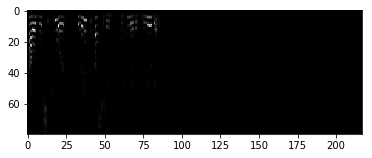

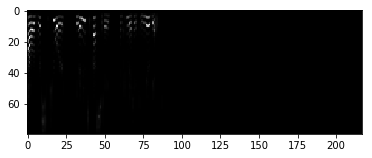

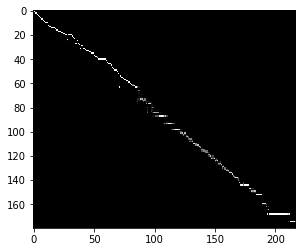

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 186, LOSS 0.02269256371003923, BEST LOSS 0.02269256371003923 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 186



epoch 186 total 0.022692322636495774
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.026781590655446053
PAD INDEX 0
TEXT another two hundred more or less took advantage of "the rules," and lived outside within a circumference of two miles and a half.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


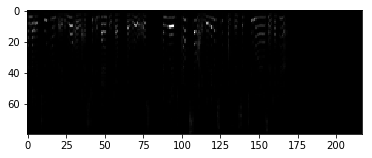

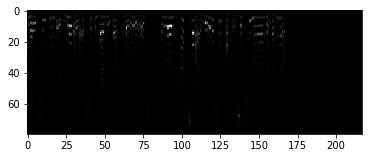

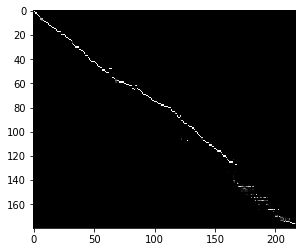

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 187, LOSS 0.022692322636495774, BEST LOSS 0.022692322636495774 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 187


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 189 total 0.022685564192595768
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.025959089398384094
PAD INDEX 0
TEXT many of these cases were not investigated by prs.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


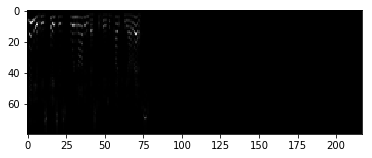

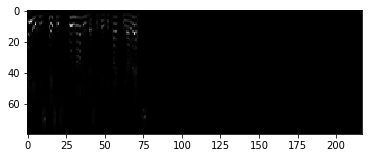

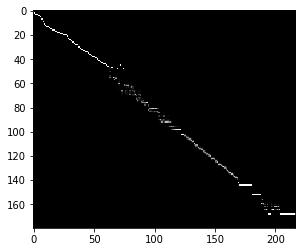

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 190, LOSS 0.022685564192595768, BEST LOSS 0.022685564192595768 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 190



epoch 190 total 0.022695487437408363
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.03584333509206772
PAD INDEX 0
TEXT during the autopsy examination, federal agents brought the surgeons three pieces of bone recovered from elm street and the presidential automobile.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


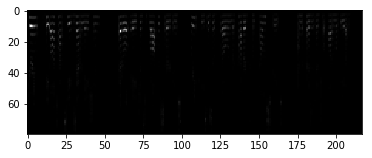

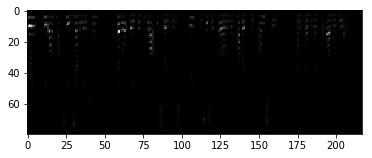

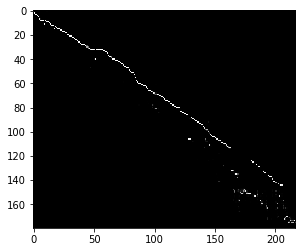

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 191, LOSS 0.022695487437408363, BEST LOSS 0.022685564192595768 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 191



epoch 191 total 0.02266805705322481
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.015920568257570267
PAD INDEX 0
TEXT at his own request,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


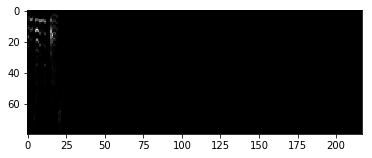

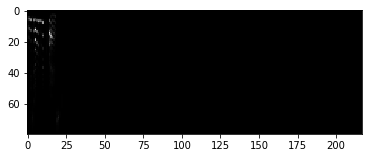

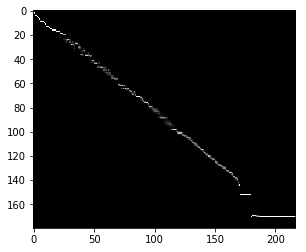

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 192, LOSS 0.02266805705322481, BEST LOSS 0.02266805705322481 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 192


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



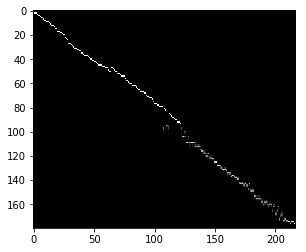

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 195, LOSS 0.022671288999714958, BEST LOSS 0.02266805705322481 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 195



epoch 195 total 0.022666662920321993
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.02139279432594776
PAD INDEX 0
TEXT end quote, followed by a scurrilous bill of particulars that constituted a vilification of the president.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


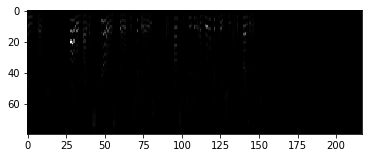

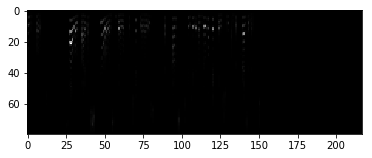

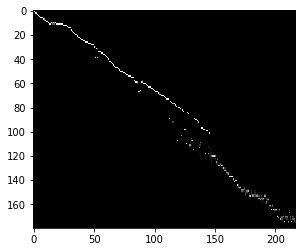

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 196, LOSS 0.022666662920321993, BEST LOSS 0.022666662920321993 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 196



epoch 196 total 0.022661368056798158
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.0198768749833107
PAD INDEX 0
TEXT was his service in japan.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


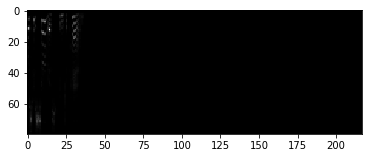

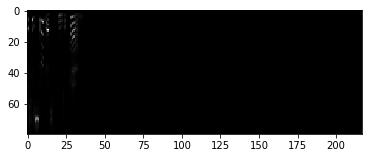

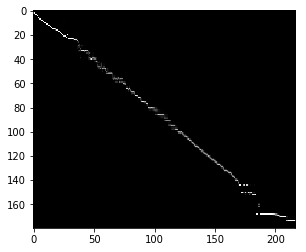

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 197, LOSS 0.022661368056798158, BEST LOSS 0.022661368056798158 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 197


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 199 total 0.022659900328561442
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.02385355904698372
PAD INDEX 0
TEXT at that point, both governor and mrs. connally observed brain tissue splattered over the interior of the car.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


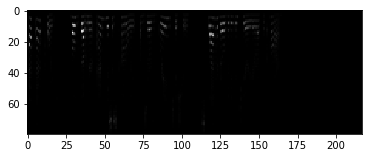

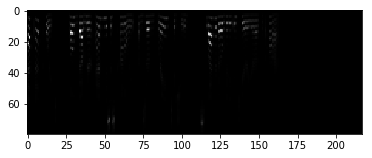

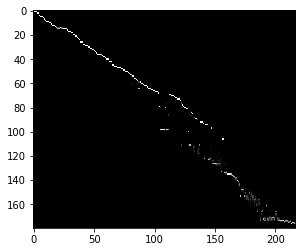

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 200, LOSS 0.022659900328561442, BEST LOSS 0.022659900328561442 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 200



epoch 200 total 0.02265073522758573
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.017861977219581604
PAD INDEX 0
TEXT even after the death sentence had been passed upon him he clung to the hope that the government would grant him a reprieve.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


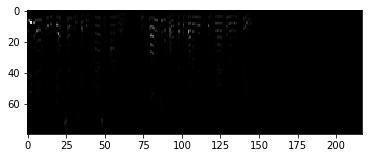

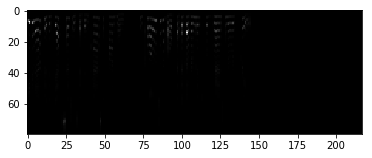

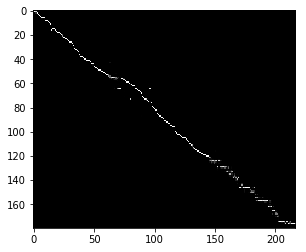

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 201, LOSS 0.02265073522758573, BEST LOSS 0.02265073522758573 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 201



epoch 201 total 0.022662112385090163
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.029406985267996788
PAD INDEX 0
TEXT probably this freed oxygen is used for the purpose of oxygenation, but more is freed in the photosynthetic process than is needed for oxygenationNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


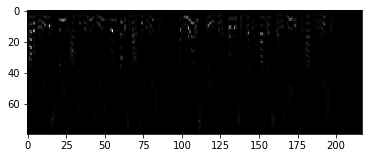

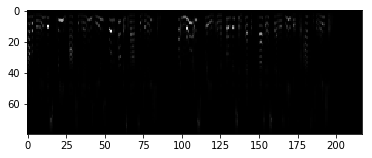

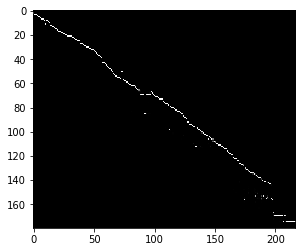

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 202, LOSS 0.022662112385090163, BEST LOSS 0.02265073522758573 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 202


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 204 total 0.022650118230550145
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.024657033383846283
PAD INDEX 0
TEXT and under the scanty covering of a couple of dirty stable-rugs apiece.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


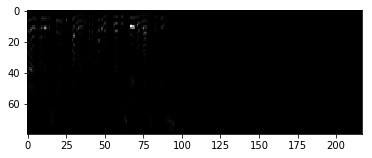

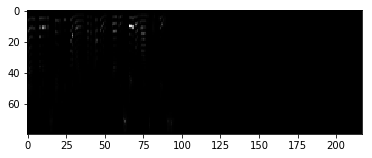

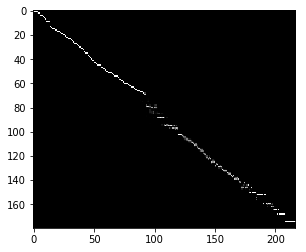

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 205, LOSS 0.022650118230550145, BEST LOSS 0.022650118230550145 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 205



epoch 205 total 0.022643764350396483
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.021447671577334404
PAD INDEX 0
TEXT but is only an ordinary commonplace tool.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


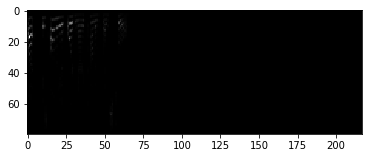

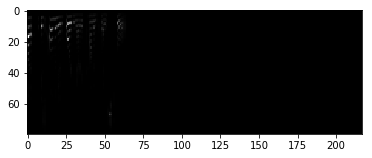

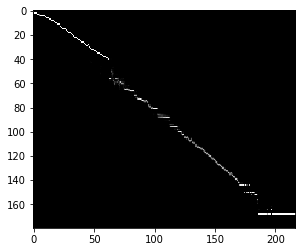

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 206, LOSS 0.022643764350396483, BEST LOSS 0.022643764350396483 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelBest.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 206



epoch 206 total 0.02264831333018061
[torch.Size([1, 180]), torch.Size([1, 80, 217]), torch.Size([1, 513, 868]), torch.Size([1])]
LOSS: 0.02691914141178131
PAD INDEX 0
TEXT his morals by compelling him to mix with a promiscuous assemblage of hardened and convicted criminals,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


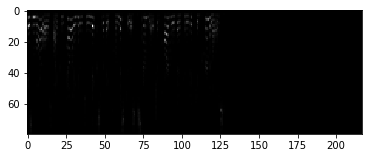

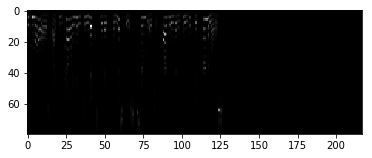

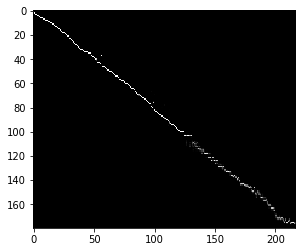

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 207, LOSS 0.02264831333018061, BEST LOSS 0.022643764350396483 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar', './text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar']
EPOCH 207


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
text2MelWrapper.train(numEpochs=100)

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
LOADED EPOCH 208, LOSS 0.022649761934333774, BEST LOSS 0.022643764350396483 FROM ./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/text2MelLast.5a9d0e2b5efa755db9db30ef6cd50aacb4de66b8ae4ba9664da6f5a18cb3fbed.chkpt.tar


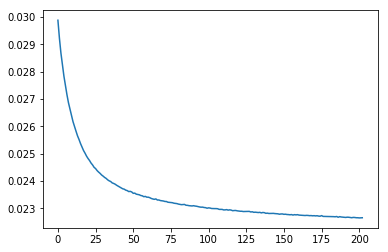

In [9]:
text2MelWrapper.load()
plt.plot(text2MelWrapper.lossHist[5:])

In [10]:
def ssrnLossFun(ssrn,batch):
    _,bS,bY,_ = batch
    Yhat = ssrn(bS)
    return SpecLossFun(Yhat,bY)

def ssrnDispFun(ssrn,batch):
    bL,bS,bY,i = [t[0:1] for t in batch] # only use first element of batch
#     print([t.device for t in batch])
    print('LOSS:',ssrnLossFun(ssrn,batch).item())
    print(bS.shape)
    Yhat = ssrn(bS)
    bL,bS,bY,Yhat,i = [t[0].cpu().detach().numpy() for t in (bL,bS,bY,Yhat,i)]
    print('PAD INDEX',i)
    print('TEXT',"".join(ssrn.params.i2c[c] for c in bL))
    plt.imshow(bS,cmap='gray')
    plt.show()
    plt.imshow(bY,cmap='gray')
    plt.show()
    plt.imshow(Yhat,cmap='gray')
    plt.show()

In [11]:
ssrnParams = hyperparams.Hyperparams(sep=0,dropout=0)
# nWorkers = 8 if ch.cuda.is_available() else 0
nWorkers = 6 if ch.cuda.is_available() else 0
ssrnLoader = Data.DataLoader(datasets.LJSpeechDataset(ttmel=0),
                             batch_size=16,
                             shuffle=True,
                             num_workers=nWorkers)
ssrn = dcttsModel.SSRN(ssrnParams).to(dev)
ssrnOpt = ch.optim.Adam(ssrn.parameters(),lr=ssrnParams.lr,
                        betas=(ssrnParams.b1,ssrnParams.b2),
                        eps=ssrnParams.eps)
ssrnWrapper = utils.ModelWrapper(network=ssrn,optimizer=ssrnOpt,
                                 lossFun=ssrnLossFun,loader=ssrnLoader,
                                 modelName='ssrn',dev=dev,dispFun=ssrnDispFun)

INITIALIZED ssrn WITH HYPERPARAMS {'sep': 0, 'alpha': 1, 'dropout': 0, 'norm': 2, 'lr': 0.001, 'chunk': 1, 'pad': 0, 'reversedDilation': 0}
TOTAL PARAM COUNT 24980141


In [12]:
ssrnWrapper.load()

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
LOADED EPOCH 50, LOSS 0.09983097643994573, BEST LOSS 0.09983097643994573 FROM ./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar


EPOCH 50



epoch 50 total 0.09981104121056955
LOSS: 0.08078064024448395
torch.Size([1, 80, 64])
PAD INDEX 0
TEXT watts led two lives.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


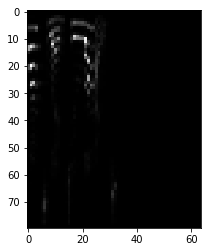

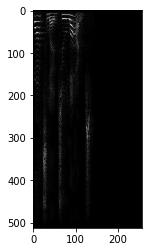

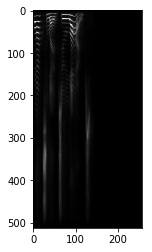

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 51, LOSS 0.09981104121056955, BEST LOSS 0.09981104121056955 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 51



epoch 51 total 0.09978882824974274
LOSS: 0.08955573290586472
torch.Size([1, 80, 64])
PAD INDEX 110
TEXT atop this carton was a small carton marked "rolling readers," measuring approximately thirteen by nine by eight inches.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


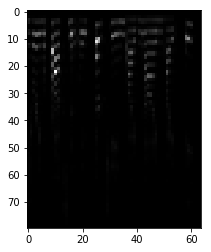

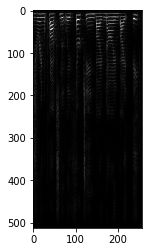

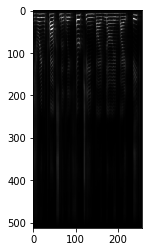

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 52, LOSS 0.09978882824974274, BEST LOSS 0.09978882824974274 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 52


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 55 total 0.09980837009958367
LOSS: 0.09264420717954636
torch.Size([1, 80, 64])
PAD INDEX 10
TEXT then mrs. daulby learnt that miss turner had not arrived at shrigley, but that she had gone to manchester.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


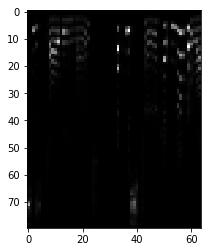

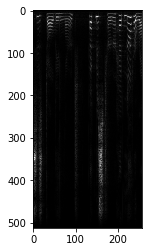

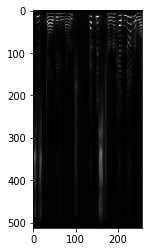

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 56, LOSS 0.09980837009958367, BEST LOSS 0.09977691627260464 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 56



epoch 56 total 0.09970901946523296
LOSS: 0.10537157207727432
torch.Size([1, 80, 64])
PAD INDEX 77
TEXT the fact that oswald left behind the funds which might have enabled him to reach cuba suggests the absence of any plan to try to flee thereNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


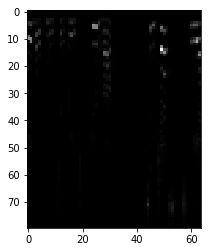

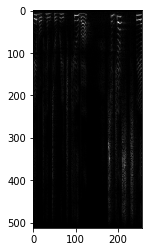

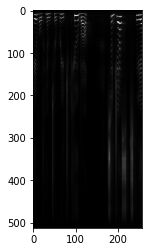

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 57, LOSS 0.09970901946523296, BEST LOSS 0.09970901946523296 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 57


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 59 total 0.099580659494916
LOSS: 0.08148334920406342
torch.Size([1, 80, 64])
PAD INDEX 66
TEXT with national power, intended as they said, "to form a more perfect unionNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


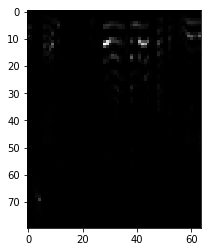

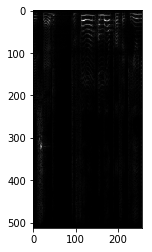

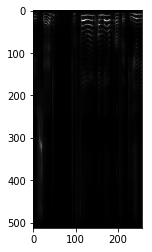

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 60, LOSS 0.099580659494916, BEST LOSS 0.099580659494916 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 60



epoch 60 total 0.09961562325705343
LOSS: 0.11153299361467361
torch.Size([1, 80, 64])
PAD INDEX 2
TEXT secret service emergency security arrangementsNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


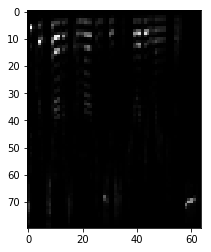

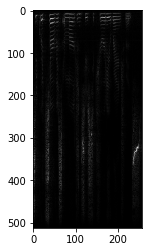

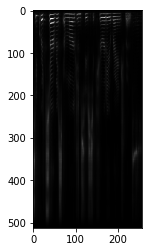

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 61, LOSS 0.09961562325705343, BEST LOSS 0.099580659494916 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 61



epoch 61 total 0.0997117300309352
LOSS: 0.09108629077672958
torch.Size([1, 80, 64])
PAD INDEX 39
TEXT he subsequently found a job with the texas school book depository for which he performed his duties satisfactorily.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


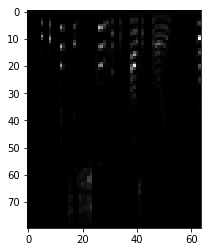

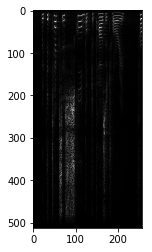

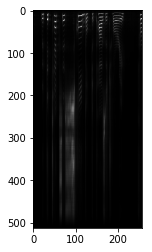

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 62, LOSS 0.0997117300309352, BEST LOSS 0.099580659494916 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 62


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 64 total 0.09963074692372066
LOSS: 0.09321457147598267
torch.Size([1, 80, 64])
PAD INDEX 40
TEXT no edition of either dallas newspaper during the period january one, nineteen sixty-three, to may fifteen, nineteen sixty-three,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


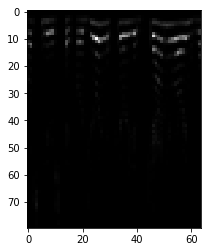

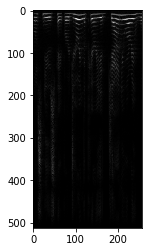

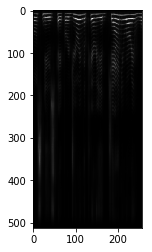

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 65, LOSS 0.09963074692372066, BEST LOSS 0.09955741701953447 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 65



epoch 65 total 0.0994834411611308
LOSS: 0.09770822525024414
torch.Size([1, 80, 64])
PAD INDEX 24
TEXT starch, however, contains potential energy, since the molecule is relatively unstableNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


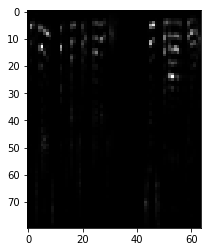

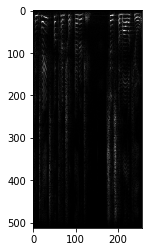

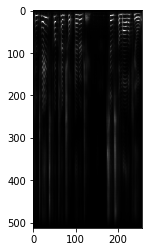

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 66, LOSS 0.0994834411611308, BEST LOSS 0.0994834411611308 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 66


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 69 total 0.09952225996487177
LOSS: 0.08879560977220535
torch.Size([1, 80, 64])
PAD INDEX 82
TEXT the surgeons observed, through x-ray analysis, thirty or forty tiny dustlike fragments of metalNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


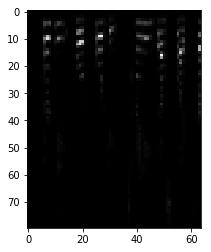

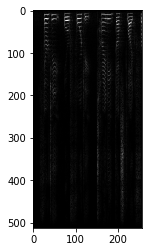

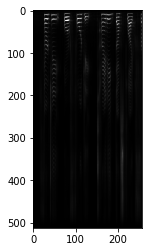

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 70, LOSS 0.09952225996487177, BEST LOSS 0.09941270250215459 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 70



epoch 70 total 0.09943742243878877
LOSS: 0.10583934187889099
torch.Size([1, 80, 64])
PAD INDEX 0
TEXT at the sound of the second shotNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


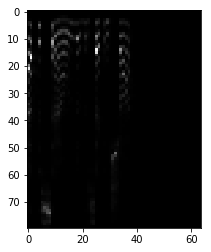

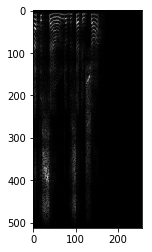

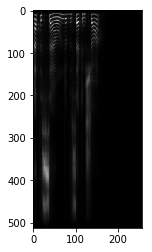

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 71, LOSS 0.09943742243878877, BEST LOSS 0.09941270250215459 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 71


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 74 total 0.09930279273817788
LOSS: 0.08420887589454651
torch.Size([1, 80, 64])
PAD INDEX 29
TEXT it is only fair to mr. cotton to add that, according to his own journal, he was unremitting in his attentions to convicts who were actually cast for death,NNNNNNNNNNNNNNNNNNNNNNNNN


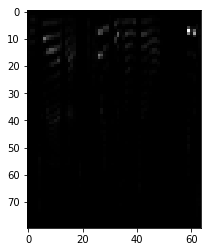

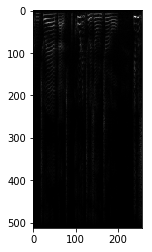

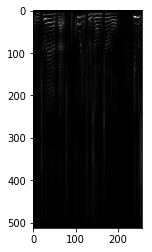

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 75, LOSS 0.09930279273817788, BEST LOSS 0.09930279273817788 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 75



epoch 75 total 0.09938614051511038
LOSS: 0.12713998556137085
torch.Size([1, 80, 64])
PAD INDEX 98
TEXT or the inspectors of prisons, and that he be required wholly to confine himself to the performance of his duty as prescribed by act of parliament.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


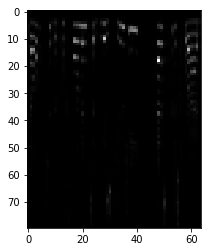

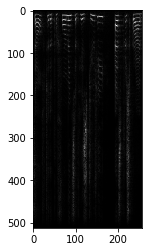

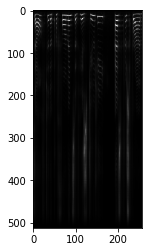

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 76, LOSS 0.09938614051511038, BEST LOSS 0.09930279273817788 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 76


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 79 total 0.09929967095602804
LOSS: 0.09131646156311035
torch.Size([1, 80, 64])
PAD INDEX 37
TEXT he was taken to a hospital in moscow where he was kept until october twenty-eight, nineteen fifty-nine.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


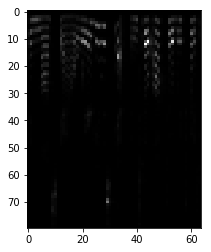

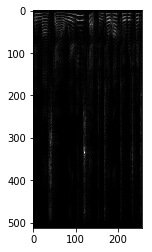

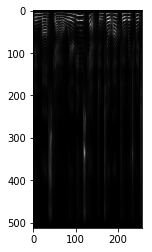

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 80, LOSS 0.09929967095602804, BEST LOSS 0.09929967095602804 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 80



epoch 80 total 0.09942891865746299
LOSS: 0.11412771791219711
torch.Size([1, 80, 64])
PAD INDEX 125
TEXT it was one of these, glendinning, who had allowed himself to be utilized for some time in this way, whose capture led to the breaking up of the gang.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


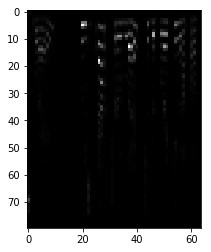

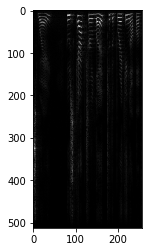

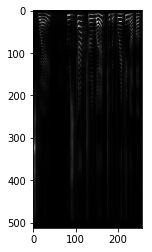

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 81, LOSS 0.09942891865746299, BEST LOSS 0.09929967095602804 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 81


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 84 total 0.09934334443576301
LOSS: 0.07616963982582092
torch.Size([1, 80, 64])
PAD INDEX 38
TEXT it would have been possible for him to take different routes in approaching and leaving the scene of the shooting.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


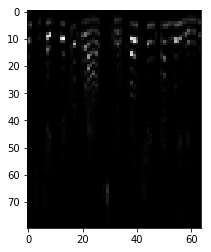

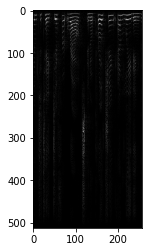

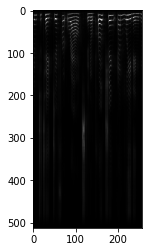

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 85, LOSS 0.09934334443576301, BEST LOSS 0.09929967095602804 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 85



epoch 85 total 0.09937324488340919
LOSS: 0.11510752141475677
torch.Size([1, 80, 64])
PAD INDEX 11
TEXT these agents performed for the vice president the same functions that the agents in the presidential follow-up car performed for the president.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


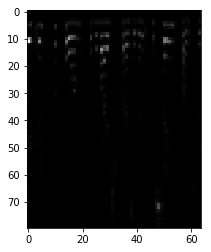

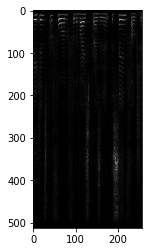

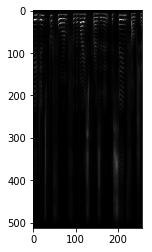

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 86, LOSS 0.09937324488340919, BEST LOSS 0.09929967095602804 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 86


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 89 total 0.09936766069549233
LOSS: 0.11037914454936981
torch.Size([1, 80, 64])
PAD INDEX 22
TEXT a note which oswald left for his wife on the evening of the shooting,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


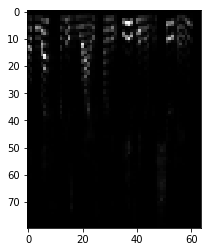

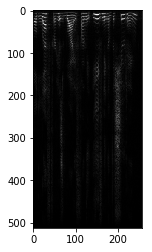

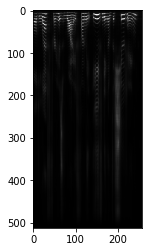

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 90, LOSS 0.09936766069549233, BEST LOSS 0.09929967095602804 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 90



epoch 90 total 0.09943668013855593
LOSS: 0.1339174509048462
torch.Size([1, 80, 64])
PAD INDEX 29
TEXT in the second edition of the "regne animal," published in eighteen twenty-eight,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


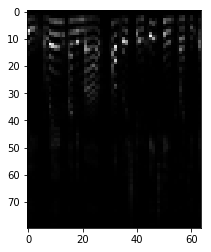

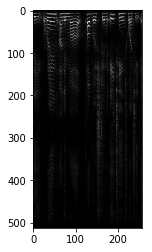

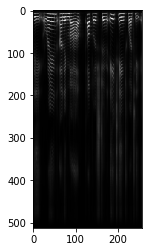

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 91, LOSS 0.09943668013855593, BEST LOSS 0.09929967095602804 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 91


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




epoch 94 total 0.09929678881568695
LOSS: 0.09717395901679993
torch.Size([1, 80, 64])
PAD INDEX 96
TEXT the commission notes with approval several recent measures taken and proposed by the secret service to improve its liaison arrangements.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


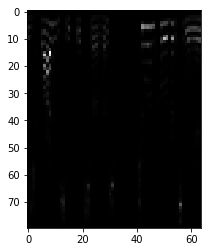

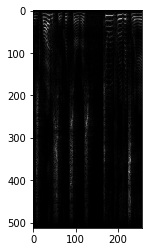

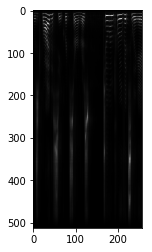

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 95, LOSS 0.09929678881568695, BEST LOSS 0.09925151098130354 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 95



epoch 95 total 0.09927079498545448
LOSS: 0.1029285341501236
torch.Size([1, 80, 64])
PAD INDEX 15
TEXT it does not appear that he ever lost his job because of its activities, although he may well not have been aware of that fact.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


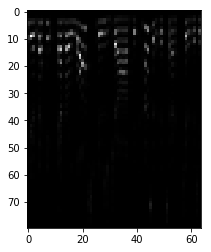

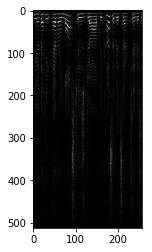

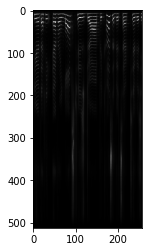

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 96, LOSS 0.09927079498545448, BEST LOSS 0.09925151098130354 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']
EPOCH 96


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



EPOCH 99



epoch 99 total 0.09922895945275008
LOSS: 0.10363578051328659
torch.Size([1, 80, 64])
PAD INDEX 23
TEXT but his scribe wrote it in the manner customary for the scribes of those days to write of their royal masters.NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN


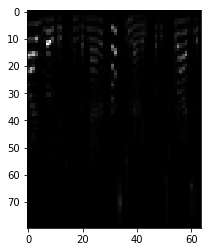

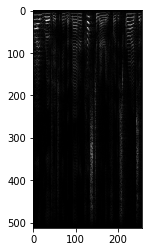

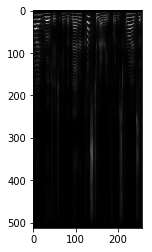

HYPERPARAMS sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0
SAVED EPOCH 100, LOSS 0.09922895945275008, BEST LOSS 0.09922895945275008 TO ['./sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnLast.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './sep:0|alpha:1|dropout:0|norm:2|lr:0.001|chunk:1|pad:0|reversedDilation:0/ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar', './ssrnBest.a0b4384e1c98dc73f7f2ad2ac44bd5841f8778715c01d183ca213498c659aac8.chkpt.tar']


In [13]:
ssrnWrapper.train(numEpochs=50)